## Part 1: scatter plot between all nitrate and phosphate samples deeper than 500 dbar and draw a Type I regression line

In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

filename = 'wcoa_cruise/WCOA2013_hy1.csv'
df = pd.read_csv(filename, header=31, 
                 na_values=-999, parse_dates=[[8,9]])

<IPython.core.display.Javascript object>


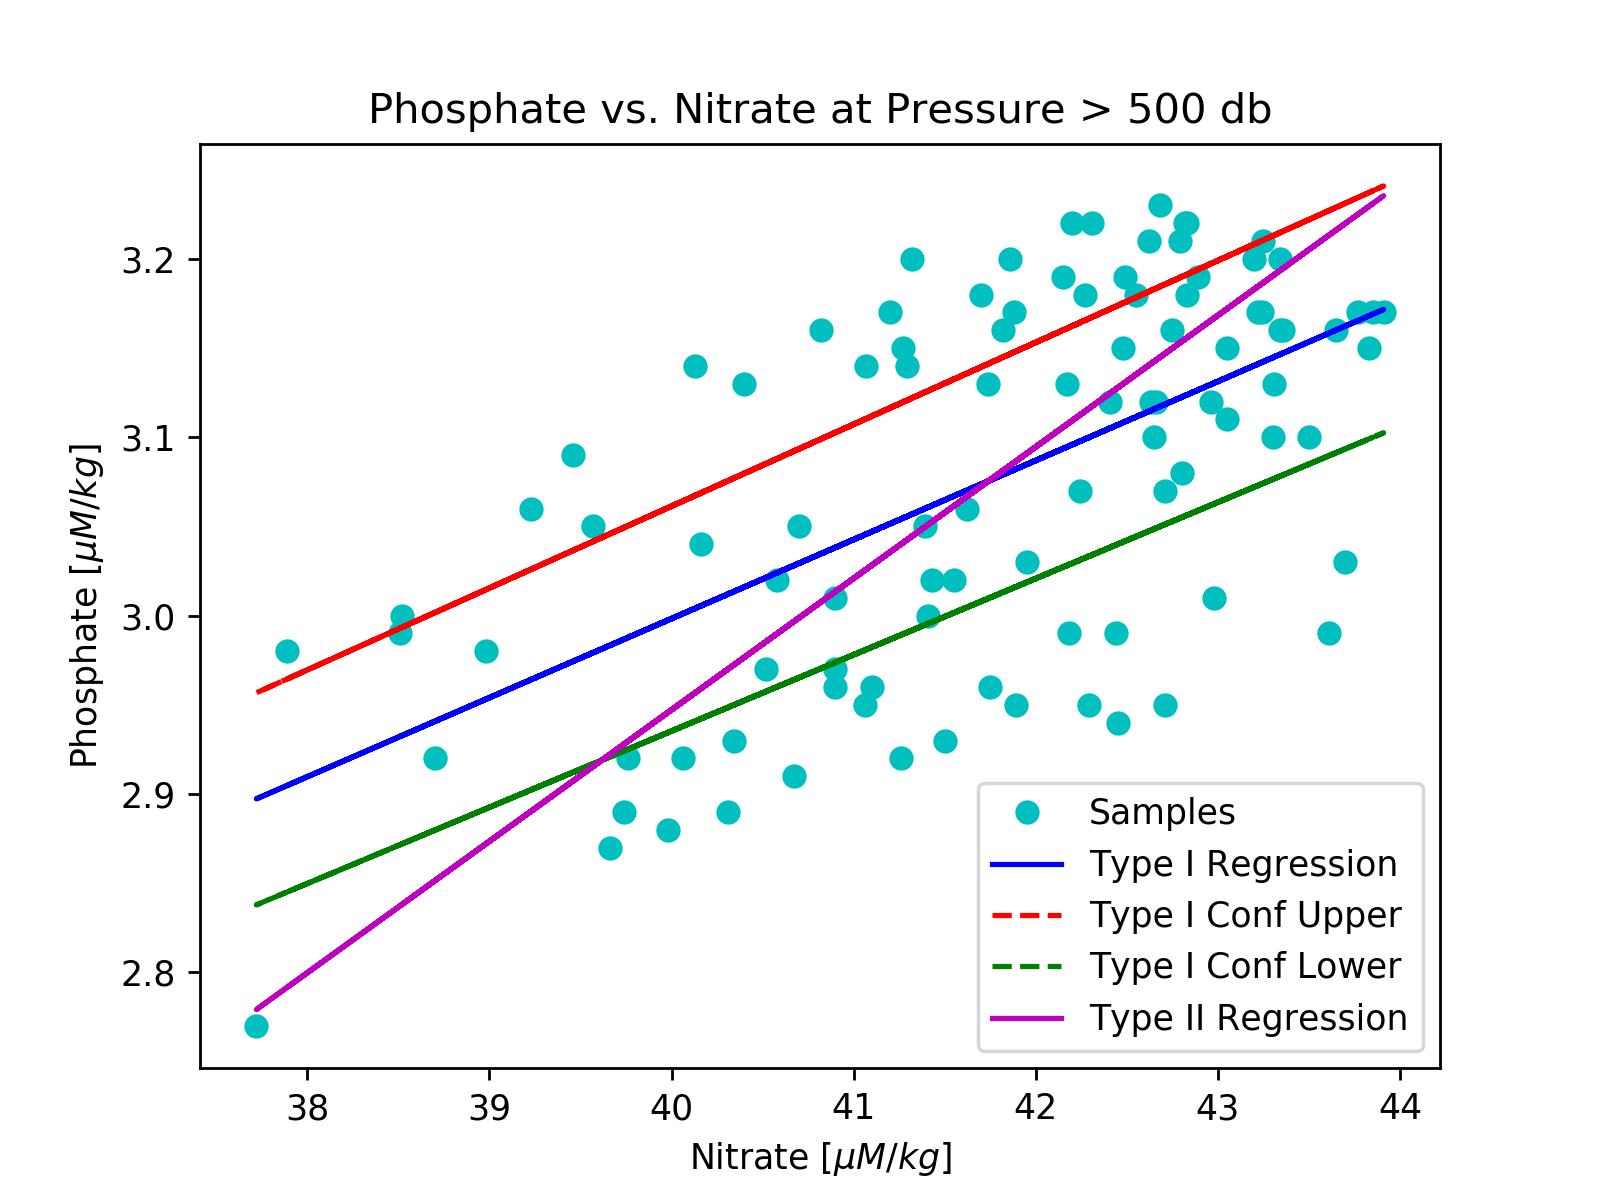

In [2]:
ii, = np.where(df['CTDPRS']>500) #where in the data set (which rows) is the pressure > 500db

#plot nitrate vs. phosphate at index ii where pressure > 500db
plt.figure()
plt.plot(df['NITRAT'][ii],df['PHSPHT'][ii],'co',label='Samples')
plt.title('Phosphate vs. Nitrate at Pressure > 500 db')
plt.xlabel('Nitrate $[\mu M / kg]$')
plt.ylabel('Phosphate $[\mu M / kg]$')

#make variables easier and make an index to ignore the nans
x = df['NITRAT'][ii] 
y= df['PHSPHT'][ii] 
jj = (np.isfinite(x) & np.isfinite(y)) 

#calculate linear regression terms and line
result = stats.linregress(x[jj],y[jj])
a = result.slope
b = result.intercept
regline = (a*x)+(b)

#plot on the same figure above
plt.plot(x,regline,'-b',label='Type I Regression') 



# Parts 2,3,4 -> Regress.py (need to make package to import)

In [3]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import pandas as pd

def slope_ci(x,y,alpha=0.05):
    ''' Compute the confidence intervals for the slope of the 
    Type I regression between x and y.
    
    INPUTS:
    x - independent variable values
    y - dependent variable values (must be same length as x)
    alpha - significance level (default 0.05 for 95% confidence)
    
    OUTPUT:
    slope_lower,slope_upper - bounds of confidence interval
    '''
    #first - ignore the nans in x and y and reassign variables
    jj = (np.isfinite(x) & np.isfinite(y)) 
    x = np.array(x[jj]) #make into array because pd series is weird (?)
    y = np.array(y[jj])
    
    #calculate the slope of the type I regression line for comparison later
    result = stats.linregress(x,y)
    a = result.slope
    b = result.intercept
    yhat = a*x + b #y values as a result of model
    
    #find means and degrees of freedom
    meanx = np.mean(x)
    meany = np.mean(y)
    dfree = (len(x)+len(y))/2 - 2 #this function should assume the same number of samples in each variable
    #but what if there is a diff number of nans?? 
    
    #calculate regression slope of fit (ahat)
    ahat = (sum((x-meanx)*(y-meany))/(sum((x-meanx)**2)))
    
    #find critical t value
    tcrit = stats.t.ppf(1-alpha,df=dfree)   

    #find std error (Se)
    SSE = sum((y-yhat)**2)
    Se = np.sqrt(SSE/dfree)
    
    #define lower and upper confidence 
    slope_lower = ahat - tcrit*(np.sqrt((Se**2)/(sum(x+meanx))))
    slope_upper = ahat + tcrit*(np.sqrt((Se**2)/(sum(x+meanx))))

    return slope_lower, slope_upper

def rcrit(nu,alpha=0.95):
    """
    Critical r (correlation coefficient), given significance level
    and degrees of freedom.
    
    INPUTS:
    nu - degrees of freedom (N-2)        
    alpha - significance level (default 0.05 for 95% confidence)
    
    OUTPUT:
    rcrit - critical r value
    
    Values for 0.05 and 0.01 correspond with Appendix E in
    Emery and Thomson (2004) Data Analysis Methods in Physical 
    Oceanography
    """
    #find means and degrees of freedom
    meanx = np.mean(x)
    meany = np.mean(y)
    
    #find std deviations & covariance
    sx = np.std(x,ddof=1)
    sy = np.std(y,ddof=1)
    Sxy2 = (1/(nu+1)*sum((x-meanx)*(y-meany)))

    #calculate critical r
    rcrit = Sxy2/(sx*sy) #compare this to table for significance of correlation
    
    return rcrit

def type2regress(x,y):
    """
    Type II Linear regression.
    
    INPUTS:
    x,y - two different variables
    
    OUTPUT:
    slope, intercept
    
    """
    #use linregress to get slope of y from x
    resultyx = stats.linregress(x,y)
    m_yx = resultyx.slope
   
    #use linregress to get slope of x from y and calculate geometric mean
    resultxy = stats.linregress(y,x)
    m_xy = resultxy.slope
    
    #Type II slope (aka the geometric mean)
    slope = np.sqrt(m_yx/m_xy) 
    
    #Type II intercept
    intercept = np.mean(y) - np.mean(x)*slope

    return slope,intercept


# Plot the Confidence Intervals for Type I

In [4]:
slope_lower, slope_upper = slope_ci(x[jj],y[jj],alpha=.05)
confupper = slope_upper*x[jj] + b
conflower = slope_lower*x[jj] + b

plt.plot(x[jj], confupper,'--r',label='Type I Conf Upper')
plt.plot(x[jj], conflower,'--g',label='Type I Conf Lower')

# Part 5: Draw Type II Regression line

In [5]:
slope,intercept = type2regress(x[jj],y[jj])
typeII_line = slope*x[jj] + intercept
plt.plot(x[jj],typeII_line,'-m',label='Type II Regression') 


plt.legend()

-the strength and significance of the correlation in #1
    The strength and significance of the correlation between phosphate and nitrate is described by the r-critical value found in Part 3. The r-critical value found was 0.601, which was greater than the value found on the table (Appendix E: Correlation Coefficients at the 5%...). The value on the table for 5% confidence and around 96 degrees of freedom was between .195 and .205. Since the r-critical value we found (.601) > ~.2, concluding that the phosphate is significantly correlated with nitrate. The closer to 1 the r-critical value is the better the correlation, so this isn't the strongest correlation possible.

-the applicability of a Type I or Type II linear regression model
    Type I regression has the underlying assumption that the y variable is dependent on the x variable, while Type II regression assumes that both the x and y variables are independent. For this assignment, since nitrate and phosphate are independent of eachother, the Type II regression is more applicable. However, if we wanted to compare the change of nitrate depending on depth or either phosphate or nitrate and time, the Type I regression would be more applicable since the changes in nitrate or phosphate with depth and time respectively, would be dependent.


-your oceanographic interpretation
    Since we found a correlation of .6 and nitrate and phosphate are independent, we can posit that perhaps both of these variables depend on another process. Phosphate and nitrate can be affected by depth, high nutrient runoff from land, productivity, and etc. Maybe one of these is a common variable that both nitrate and phosphate are dependent on.